In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from librosa import core, onset, feature, display
import soundfile as sf
import umap
from IPython.display import Audio
import sklearn

In [3]:
df = pd.read_csv("B:/SEM 3/Sound Classification/birdsong_metadata.csv")
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [4]:
def load_audio(file_id):
    data, samplerate = sf.read("B:/SEM 3/Sound Classification/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = feature.melspectrogram(data, sr=samplerate, hop_length=512)
    
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

In [5]:
df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    #print(len(data[audio_mask])/sample_rate)

In [6]:
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0


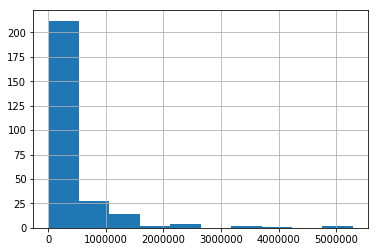

count    2.640000e+02
mean     4.307551e+05
std      6.611081e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [7]:
df['length'].hist()
plt.show()
df['length'].describe()

In [8]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df.head(30)

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length,windows
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0,41
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0,8
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0,7
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0,24
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0,15
5,64686,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,205312.0,33
6,120664,Acrocephalus,schoenobaenus,Sedge Warbler,david m,United Kingdom,56.5860,-6.1855,"male, song",http://creativecommons.org/licenses/by-nc-nd/3.0/,5286262.0,860
7,120666,Acrocephalus,schoenobaenus,Sedge Warbler,david m,United Kingdom,56.5860,-6.1855,"male, song",http://creativecommons.org/licenses/by-nc-nd/3.0/,1060864.0,172
8,76767,Acrocephalus,schoenobaenus,Sedge Warbler,Richard Dunn,United Kingdom,55.2809,-1.5801,song,http://creativecommons.org/licenses/by-nc-nd/2.5/,104448.0,17
9,124052,Acrocephalus,scirpaceus,Eurasian Reed Warbler,david m,United Kingdom,51.8985,-0.5372,"call, female, male, song",http://creativecommons.org/licenses/by-nc-nd/3.0/,1037824.0,168


In [9]:
# We use 23 windows per genus to have a balanced data set

n_windows = df.groupby('species')['windows'].sum().min()
n_windows

20

In [10]:
# First we create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])
        

In [11]:
# We randomly pick 20 windows for each species

# Save other samples for testing

windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

In [12]:
# Extract Features from Window
new_dataset = pd.DataFrame()

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset = new_dataset.append(data_point,ignore_index=True)

new_dataset.head()

C:\Users\rtanu\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,...,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,1.000000,0.833207,0.770394,0.702116,0.655413,0.326867,0.922793,0.313101,0.493068,0.167065,...,2503.140943,2731.402739,2610.782378,2702.360640,2675.551167,2817.795126,2708.001038,2738.732677,2687.312293,flammea
1,0.982724,0.826883,0.768728,0.702757,0.662904,0.328242,0.924370,0.311240,0.492785,0.167188,...,2501.371362,2731.110899,2610.496832,2702.711164,2675.828998,2817.996191,2707.371616,2739.432406,2686.417157,flammea
2,0.986246,0.828101,0.767894,0.703366,0.664334,0.328939,0.925159,0.310319,0.492645,0.167255,...,2502.520326,2730.963584,2610.355897,2702.883833,2675.969849,2818.093899,2707.057771,2739.780883,2685.969365,flammea
3,1.000000,0.904057,0.749178,0.708311,0.676812,0.318977,0.899720,0.284723,0.506305,0.168488,...,2511.527083,2730.666135,2610.077567,2703.223986,2676.255549,2818.283778,2706.431852,2740.475066,2685.073256,flammea
4,1.000000,0.905504,0.745879,0.710330,0.679618,0.321715,0.902318,0.281567,0.505713,0.168698,...,2501.661614,2730.059861,2609.534493,2703.883625,2676.844815,2818.641780,2705.187257,2741.852192,2683.279180,flammea


In [13]:
# Extract Features from Window for test
new_dataset_test = pd.DataFrame()

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed_test[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed_test[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset_test = new_dataset_test.append(data_point,ignore_index=True)

new_dataset_test.head()

,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,...,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,1.000000,0.945011,0.749241,0.714737,0.704973,0.311386,0.881971,0.280575,0.519973,0.170108,...,2486.230223,2731.690858,2611.073052,2702.003237,2675.278369,2817.586461,2708.632709,2738.029236,2688.206943,flammea
1,0.650246,0.590960,0.712450,0.909644,0.727013,0.502476,1.000000,0.242925,0.337245,0.167843,...,2502.704268,2731.547262,2610.927073,2702.182796,2675.414148,2817.691756,2708.316600,2738.381425,2687.759668,flammea
2,0.991786,0.829836,0.769562,0.702360,0.658253,0.327552,0.923582,0.312167,0.492926,0.167125,...,2500.947915,2731.257282,2610.638981,2702.536770,2675.689443,2817.896605,2707.686054,2739.083012,2686.864795,flammea
3,1.000000,0.945205,0.744401,0.716860,0.701898,0.315170,0.885456,0.275877,0.519047,0.170131,...,2503.521700,2730.815330,2610.216161,2703.054782,2676.112023,2818.189760,2706.744520,2740.128440,2685.521406,flammea
4,0.997944,0.832392,0.765386,0.704274,0.655724,0.331064,0.927524,0.307601,0.492226,0.167480,...,2507.041444,2730.515996,2609.940118,2703.391485,2676.400501,2818.375970,2706.119792,2740.820762,2684.624946,flammea


In [14]:
# Prepare dataset to fit a simple model

features= list(new_dataset.columns)
features.remove('species')
features.remove('genus')

X = new_dataset[features].values
y = new_dataset['species'].values

X_test = new_dataset_test[features].values
y_test = new_dataset_test['species'].values


In [15]:
# Use Naive Bayes as benchmark 

from sklearn import naive_bayes
NB = naive_bayes.GaussianNB()

SSS = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2)

accs = [] 

for train_index, val_index in SSS.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    NB.fit(X_train, y_train)
    
    y_pred = NB.predict(X_val)
    
    accs.append(sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_val))
    
print(accs)

[0.9005681818181818, 0.8977272727272727, 0.8636363636363636, 0.8920454545454546, 0.9090909090909091]


In [17]:
y_pred = NB.predict(X_test)
sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.9274028629856851

In [83]:
y_pred

array(['flammea', 'communis', 'flammea', 'flammea', 'flammea', 'flammea',
       'flammea', 'flammea', 'flammea', 'flammea', 'flammea', 'flammea',
       'flammea', 'flammea', 'communis', 'flammea', 'flammea', 'flammea',
       'flammea', 'flammea', 'flammea'], dtype='<U13')

In [18]:
y_pred

array(['flammea', 'communis', 'flammea', ..., 'curruca', 'curruca',
       'curruca'], dtype='<U13')

In [19]:
# The data can be used to predict, let's export the newly created datasets

new_dataset.to_csv("train.csv")
new_dataset_test.to_csv("test.csv")

Testing an audio (Rewriting the functions with new variables for easier understanding) 

In [ ]:
testfile = pd.read_csv("B:/SEM 3/Sound Classification/test1csv.csv")

In [71]:
def testaudio(test_audio):
    file, rate = sf.read("B:/SEM 3/Sound Classification/songs/xc132608.flac")
    ss = len(file)/rate
    sgs = feature.melspectrogram(file, sr=rate, hop_length=512)
   
# Take mean amplitude M from frame with highest energy
    centerpoints = np.argmax(sgs.mean(axis=0))
    Ms = sgs[:,centerpoints].mean()
  
# Filter out all frames with energy less than 5% of M
    masks = sgs.mean(axis=0)>=M/20

    audio_masks = np.zeros(len(file), dtype=bool)
    for i in range(0,len(masks)):
        audio_masks[i*512:] = masks[i]
    return sgs, masks, file, audio_masks, rate

In [73]:
testfile['length'] = np.zeros(len(testfile))

wave = {}


for test_audio in testfile['file_id']:
    sgs, masks, file, audio_masks, sample_rates = load_audio(test_audio)
    wave[test_audio] = file[audio_masks]
    testfile.loc[testfile['file_id'] == test_audio,'length'] = len(file[audio_masks])

In [74]:
testfile['windows'] = testfile['length'].apply(lambda x: int(x/6.144000e+03))

In [75]:
windowss = {}

for test_audio in testfile['file_id']:
    wavess = wave[test_audio]
    speciess = testfile[testfile['file_id']==test_audio]['genus'].values[0] + "_" + testfile[testfile['file_id']==test_audio]['species'].values[0]
    if speciess not in windowss:
        windowss[speciess] = []
    for i in range(0, int(len(wavess)/6.144000e+03)):
        windowss[speciess].append(wavess[i:int(i+6.144000e+03)])

In [76]:
windows_fixeds = {}
windows_fixed_tests = {}

for speciess in windowss.keys():
    windows_fixeds[speciess] = []
    windows_fixed_tests[speciess] = []
    wss = windowss[speciess]
    indexs = np.random.choice(len(wss), n_windows, replace=False)
    for i in range(0, len(wss)):
        if i in indexs:
            windows_fixeds[speciess].append(wss[i])
        else:
            windows_fixed_tests[speciess].append(wss[i])

In [77]:
new_datasets = pd.DataFrame()

for speciess in windows_fixeds.keys():
    for i in range(0,n_windows):
        data_points = {'species':speciess.split('_')[1], 'genus':speciess.split('_')[0]}
        spec_centroids = feature.spectral_centroid(windows_fixeds[speciess][i])[0]
        chromas = feature.chroma_stft(windows_fixeds[speciess][i], sample_rates)
        for j in range(0,13):
            data_points['spec_centr_'+str(j)] = spec_centroids[j]
            for k in range(0,12):
                data_points['chromogram_'+str(k)+"_"+str(j)] = chromas[k,j]
        new_datasets = new_datasets.append(data_points,ignore_index=True)


In [78]:
new_dataset_tests = pd.DataFrame()

for speciess in windows_fixed_tests.keys():
    for i in range(0,len(windows_fixed_tests[speciess])):
        data_points = {'species':speciess.split('_')[1], 'genus':speciess.split('_')[0]}
        spec_centroids = feature.spectral_centroid(windows_fixed_tests[speciess][i])[0]
        chromas = feature.chroma_stft(windows_fixed_tests[speciess][i], sample_rates)
        for j in range(0,13):
            data_points['spec_centr_'+str(j)] = spec_centroids[j]
            for k in range(0,12):
                data_points['chromogram_'+str(k)+"_"+str(j)] = chromas[k,j]
        new_dataset_tests = new_dataset_tests.append(data_points,ignore_index=True)


In [79]:
featuress= list(new_datasets.columns)
featuress.remove('species')
featuress.remove('genus')

Xs = new_datasets[featuress].values
ys = new_datasets['species'].values

X_tests = new_dataset_tests[featuress].values
y_tests = new_dataset_tests['species'].values

In [84]:
y_preds = NB.predict(X_tests)

In [86]:
y_preds[0]

'flammea'